# Cleaning and EDA

## Data Cleaning

### Read the data

In [2]:
import pandas as pd
import chardet

with open('Data/data.csv', 'rb') as f:
    result = chardet.detect(f.read())
    print(result['encoding'])

encoding = 'Windows-1252'  

# Read the CSV file with the detected encoding
raw_df = pd.read_csv('Data/data.csv', encoding=encoding, header=0)  

# Set column name as 'sentiment' and 'comment'
raw_df.columns = ['sentiment', 'comment']

print(df.head())

Windows-1252
  sentiment                                            comment
0   neutral  Technopolis plans to develop in stages an area...
1  negative  The international electronic industry company ...
2  positive  With the new production plant the company woul...
3  positive  According to the company 's updated strategy f...
4  positive  FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...


### Create a comment column with only nouns

In [3]:
import spacy

# Combine all comments into a single string
text = " ".join(df['comment'])

# Load the English language model
nlp = spacy.load('en_core_web_sm')

# Function to extract nouns from a comment
def extract_nouns(text):
    doc = nlp(text)
    nouns = [token.text for token in doc if token.pos_ == 'NOUN']
    return " ".join(nouns)

# Apply the function to each comment
raw_df['nouns'] = raw_df['comment'].apply(extract_nouns)

# Display the DataFrame with extracted nouns
print(raw_df.head())

# Save this new df to a new CSV file
raw_df.to_csv('Data/clean_data.csv', index=False)

  sentiment                                            comment  \
0   neutral  Technopolis plans to develop in stages an area...   
1  negative  The international electronic industry company ...   
2  positive  With the new production plant the company woul...   
3  positive  According to the company 's updated strategy f...   
4  positive  FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...   

                                               nouns  
0  Technopolis stages area meters order companies...  
1  industry company tens employees facility layof...  
2  production plant company capacity increase dem...  
3  company strategy years term sales growth range...  
4      FINANCING growth strategy circuit boards PCBs  


## EDA

utf-8


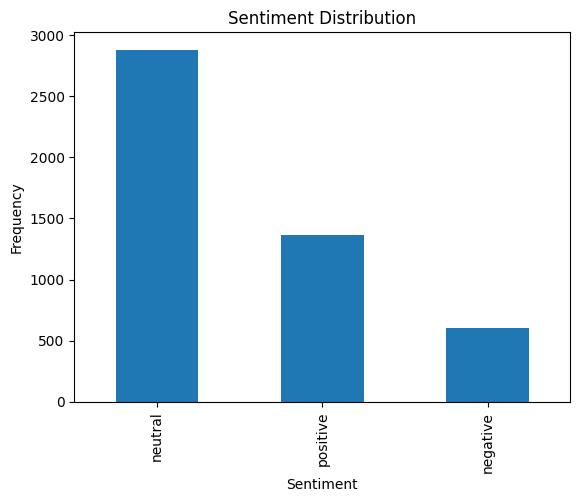

In [11]:
import pandas as pd
import chardet
import matplotlib.pyplot as plt

with open('Data/clean_data.csv', 'rb') as f:
    result = chardet.detect(f.read())
    print(result['encoding'])

encoding = 'Windows-1252'  

# Read the CSV file with the detected encoding
df = pd.read_csv('Data/clean_data.csv', encoding=encoding, header=0) 

# Plot the sentiment distribution
sentiment_count = df['sentiment'].value_counts()
sentiment_count.plot(kind = 'bar')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.show()

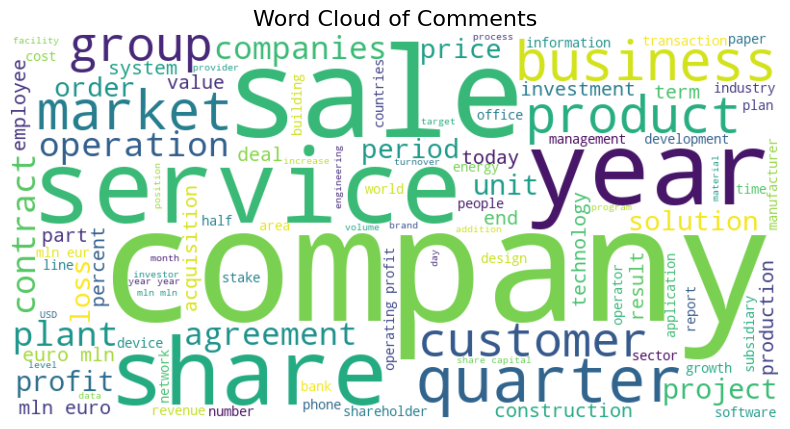

In [14]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Custom stopwords
custom_stopwords = set(STOPWORDS)
custom_stopwords.update(['will', 'mn', 'm']) 

# Create a word cloud object
wordcloud = WordCloud(
    width=800,                # Width of the canvas
    height=400,               # Height of the canvas
    background_color='white', # Background color of the word cloud
    max_words=100,            # Maximum number of words to display
    contour_color='steelblue',# Color of the contour
    contour_width=1,          # Width of the contour line
    colormap='viridis',       # Color map for the words
    stopwords=custom_stopwords            # Stopwords to exclude (default is None)
).generate(clean_df['nouns'].str.cat(sep=' '))  # Concatenate all nouns into a single string

# Display the generated word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off axis lines and labels
plt.title('Word Cloud of Comments', fontsize=16)
plt.show()


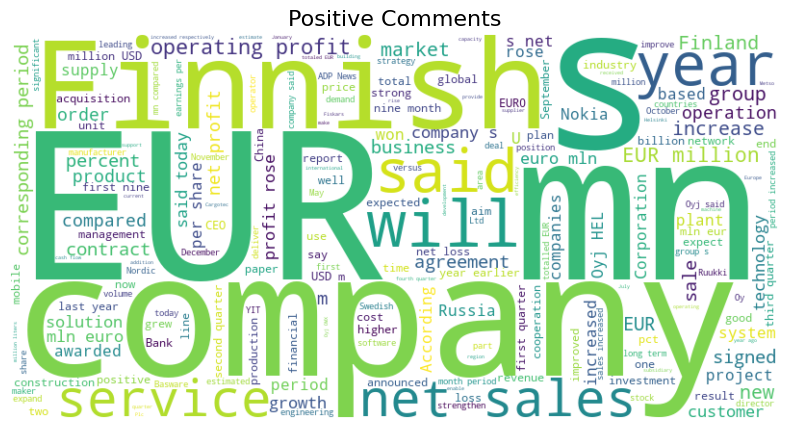

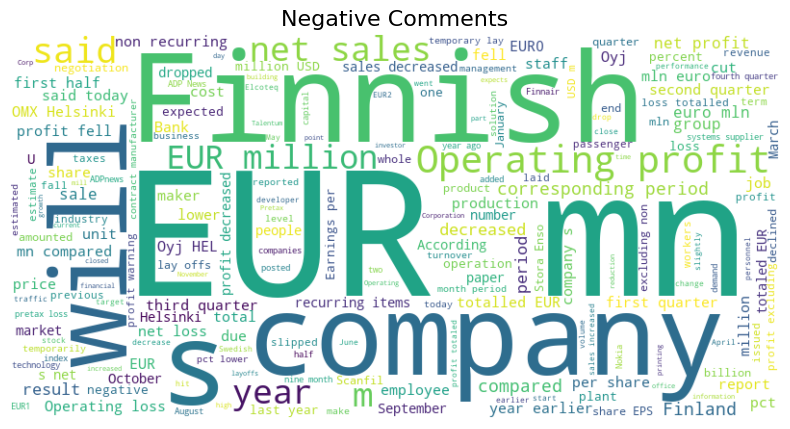

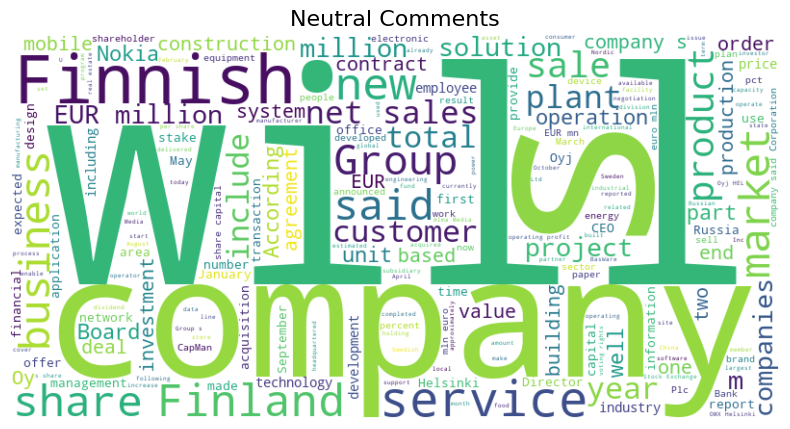

In [10]:
from wordcloud import WordCloud

def plot_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.show()

positive_text = " ".join(df[df['sentiment'] == 'positive']['comment'])
negative_text = " ".join(df[df['sentiment'] == 'negative']['comment'])
neutral_text = " ".join(df[df['sentiment'] == 'neutral']['comment'])

plot_wordcloud(positive_text, 'Positive Comments')
plot_wordcloud(negative_text, 'Negative Comments')
plot_wordcloud(neutral_text, 'Neutral Comments')
